### 1. Converting data to MNE and using its methods for spectral analysis

In this notebook I'll test a few MNE-python toolbox methods.

In [2]:
#####################################################################################################
# Read and save the LFP data and information for each trial in numpy format
#####################################################################################################
from   GDa.session          import session
from   joblib               import Parallel, delayed
import multiprocessing
import mne
import matplotlib.pyplot    as     plt
import numpy                as     np 
import matplotlib.animation as     animation

In [3]:
#####################################################################################################
# Receives a tensor [Nchannels, Nbands, Ntimes] and plot a movie containin the spec. for each channel
#####################################################################################################
def plot_movie(tensor, n_channels, t_cue_on, t_cue_off, t_match_on):
    fig = plt.figure()
    ims = []
    for i in range(n_channels):
        plt.title('Area: ' + lfp_data.readinfo['areas'][i])
        plt.ylabel('Frequency [Hz]')
        plt.xlabel('Time [ms]')
        im = plt.imshow(tensor[i], aspect='auto', cmap='jet', origin='lower', extent=[0,3.51, 6, 60])
        plt.vlines(t_cue_on/1000, 6, 60, 'g',lw=3)
        plt.vlines(t_cue_off/1000, 6, 60, 'r',lw=3)
        plt.vlines(t_match_on/1000, 6, 60,'m',lw=3)
        ims.append([im])
    ani = animation.ArtistAnimation(fig, ims, interval=100, blit=True,
                                    repeat_delay=1000)

    writergif = animation.PillowWriter(fps=1)
    plt.show()
    #ani.save('power.gif',writer=writergif)

In [4]:
#####################################################################################################
# Receives a tensor [Nchannels, Nbands, Ntimes] and plot the spec. for each channel
#####################################################################################################
def plot_figs(tensor, n_channels, t_cue_on, t_cue_off, t_match_on):
    for i in range(n_channels):
        plt.figure()
        plt.title('Area: ' + lfp_data.readinfo['areas'][i])
        plt.ylabel('Frequency [Hz]')
        plt.xlabel('Time [ms]')
        plt.imshow(tensor[i], aspect='auto', cmap='jet', origin='lower', extent=[0,3.51, 6, 60]) 
        plt.vlines(t_cue_on/1000, 6, 60, 'g',lw=3)
        plt.vlines(t_cue_off/1000, 6, 60, 'r',lw=3)
        plt.vlines(t_match_on/1000, 6, 60, 'm',lw=3)
        plt.show()

In [5]:
nmonkey = 0
nses    = 3
ntype   = 0
#####################################################################################################
# Directories
#####################################################################################################
dirs = {'rawdata':'GrayLab/',
        'results':'Results/',
        'monkey' :['lucy', 'ethyl'],
        'session':'session01',
        'date'   :[['141014', '141015', '141205', '150128', '150211', '150304'], []]
        }

# Instatiate LFP object
lfp_data = session(raw_path = dirs['rawdata'], monkey = dirs['monkey'][nmonkey], stype = 'samplecor', date = dirs['date'][nmonkey][nses], 
               session  = 1, evt_dt = [-0.65,3.00])
# Read session info
lfp_data.read_session_info()
# Read LFP data
lfp_data.read_lfp_data()

Reading data...


Here I'll get the onset and offset times of cue and match periods to indicate then on the spectral graphs.

In [6]:
lfp_data.readinfo.keys()

dict_keys(['nC', 'nP', 'nT', 'pairs', 'indt', 'fsample', 'tarray', 'channels_labels', 'dcue', 'dsm', 'stim', 'indch', 'areas', 't_cue_on', 't_cue_off', 't_match_on'])

This information can be acessed via the keys "t_cue_on", "t_cue_off", and "t_match_on".

In [7]:
print(lfp_data.readinfo['t_cue_on'])
print(lfp_data.readinfo['t_cue_off'])
print(lfp_data.readinfo['t_match_on'])

[ 851. 1093. 1021.  973.  969.  966.  835. 1046. 1002. 1008. 1066.  928.
  834.  961. 1021.  994. 1009.  957. 1064.  835.  973.  834. 1027. 1006.
  966. 1243.  835. 1032. 1013.  993.  991. 1015.  994. 1007.  953.  958.
 1020. 1035.  954. 1047.  980. 1006.  953. 1028. 1181.  988. 1022.  840.
 1044.  951.  833. 1007. 1029. 1007.  832.  988. 1006. 1028.  833.  968.
  829. 1061. 1073.  969.  927. 1061.  833.  833.  832.  833.  830. 1100.
  973. 1007. 1019.  966.  832.  833.  834. 1066.  832.  827.  833.  834.
  832.  832. 1005.  833.  832. 1037.  966.  840. 1007. 1006.  833.  833.
 1112. 1020.  965.  832.  834.  949. 1112. 1080.  998. 1073. 1023.  981.
  993.  833.  833.  993.  953.  833.  835.  834.  952. 1058.  978. 1005.
  835.  832.  828.  832.  833.  832.  996. 1139.  912. 1014.  992.  829.
 1005.  833. 1041. 1007.  980. 1014.  971. 1020. 1147.  833.  979. 1028.
 1041.  832. 1549. 1032.  832.  886.  979.  832.  989. 1205.  966. 1059.
 1032. 1046. 1032. 1232.  832.  833. 1001.  834. 11

Next I'll use "mne.EpochsArray" to create an object with the LFP data, and "mne.time_frequency.tfr_array_stockwell" to compute the spectogram for each recording channel.

In [8]:
#####################################################################################################
# Converting raw data into an Epoch Array
#####################################################################################################
info = mne.create_info(ch_names = lfp_data.readinfo['areas'].tolist(), sfreq= lfp_data.readinfo['fsample'])   
raw  = mne.EpochsArray(lfp_data.data, info)
#con, freqs, times, n_epochs, n_tapers = mne.connectivity.spectral_connectivity(raw, sfre = info['sfreq'], fmin=6, fmax=60, n_jobs=-1)  

540 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated


<ipython-input-8-2308da01f1af>:4: RuntimeWarning: Channel names are not unique, found duplicates for: {'a3', 'a8M', 'V1', 'F2', 'F1', 'DP', 'a5', 'a7B', 'a7A', 'LIP', 'V2', 'V6A'}. Applying running numbers for duplicates.
  info = mne.create_info(ch_names = lfp_data.readinfo['areas'].tolist(), sfreq= lfp_data.readinfo['fsample'])


0 bad epochs dropped


First I'll compute the spectogram for each channel but only the first trial.

In [36]:
#st_power, itc, freqs = mne.time_frequency.tfr_array_stockwell(lfp_data.data[0,:,:][np.newaxis, :, :], info['sfreq'], fmin=6, fmax=60, n_jobs=-1)

out = mne.time_frequency.tfr_array_morlet(lfp_data.data[0,:,:][np.newaxis,:, :], info['sfreq'], np.arange(4, 20, .2), output='power', n_jobs=-1)
#out = mne.time_frequency.tfr_array_multitaper(lfp_data.data[0,:,:][np.newaxis, :, :], info['sfreq'], np.arange(4, 20, .2), output='power', n_jobs=-1)

csd = mne.time_frequency.csd_array_morlet(lfp_data.data[0,:,:][np.newaxis,:, :], info['sfreq'], np.arange(4, 20, .2), n_jobs=-1 )

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done  20 out of  49 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=40)]: Done  30 out of  49 | elapsed:    0.4s remaining:    0.3s
[Parallel(n_jobs=40)]: Done  40 out of  49 | elapsed:    0.5s remaining:    0.1s


Computing cross-spectral density from epochs...
[done]


[Parallel(n_jobs=40)]: Done  49 out of  49 | elapsed:    0.5s finished


<CrossSpectralDensity  |  n_channels=0, time=0.0 to 3.65 s, frequencies=4.0, 4.2, 4.4, 4.6000000000000005, 4.800000000000001, 5.000000000000001, 5.200000000000001, 5.400000000000001, 5.600000000000001, 5.800000000000002, 6.000000000000002, 6.200000000000002, 6.400000000000002, 6.600000000000002, 6.8000000000000025, 7.000000000000003, 7.200000000000003, 7.400000000000003, 7.600000000000003, 7.800000000000003, 8.000000000000004, 8.200000000000003, 8.400000000000004, 8.600000000000005, 8.800000000000004, 9.000000000000004, 9.200000000000005, 9.400000000000006, 9.600000000000005, 9.800000000000004, 10.000000000000005, 10.200000000000006, 10.400000000000006, 10.600000000000005, 10.800000000000006, 11.000000000000007, 11.200000000000006, 11.400000000000006, 11.600000000000007, 11.800000000000008, 12.000000000000007, 12.200000000000006, 12.400000000000007, 12.600000000000009, 12.800000000000008, 13.000000000000007, 13.200000000000008, 13.40000000000001, 13.600000000000009, 13.800000000000008,

In [25]:
#con, freqs, times, n_epochs, n_tapers = mne.connectivity.spectral_connectivity(lfp_data.data[0,:,:][np.newaxis,:, :], 
#indices = ([30], [10]), sfreq=info['sfreq'], fmin = 4, fmax = 100, n_jobs=-1)
con1, freqs1, times1, n_epochs, _ = mne.connectivity.spectral_connectivity(
   lfp_data.data[0,:,:][np.newaxis,:, :], indices = ([1],[10]),method='coh', mode='cwt_morlet', sfreq=info['sfreq'], 
    cwt_freqs=np.arange(4, 100,1.), cwt_n_cycles=.1, n_jobs=-1)

Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..3.650s for estimation (3651 points)
    frequencies: 4.0Hz..99.0Hz (96 points)
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing connectivity for epochs 1..1


[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


[Connectivity computation done]


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.5s finished


(49, 80, 3651)


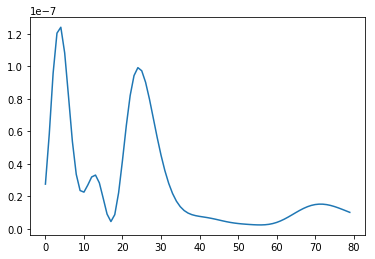

In [34]:
print(out.shape )
out = np.squeeze(out)
Wx  = out[0,:,:]
Wy  = out[1,:,:]

t = 0
C = 

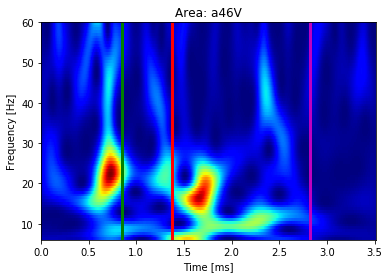

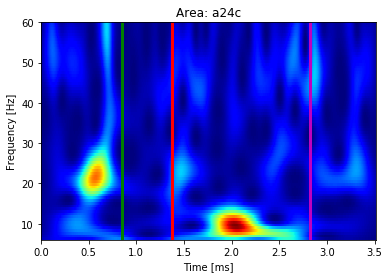

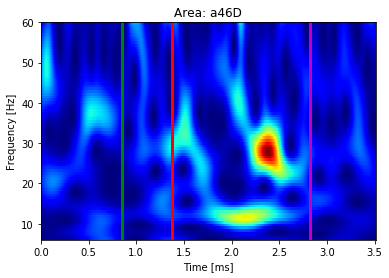

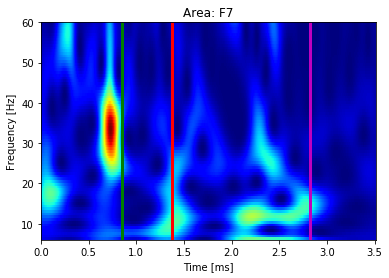

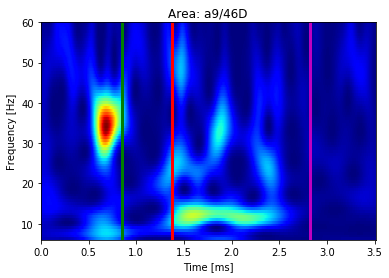

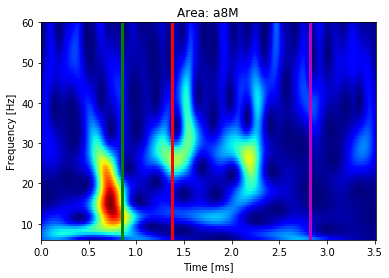

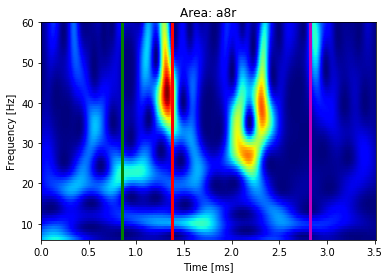

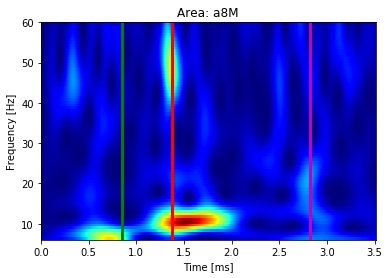

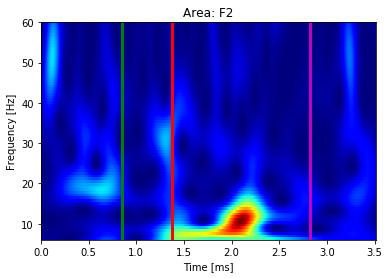

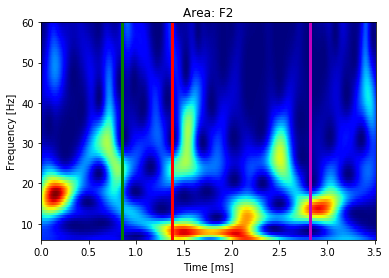

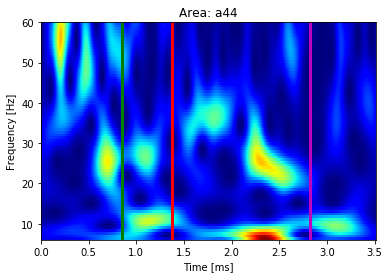

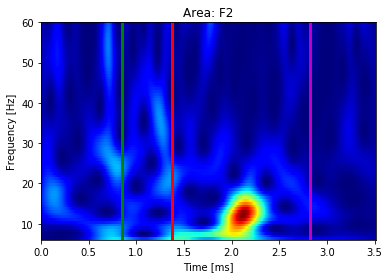

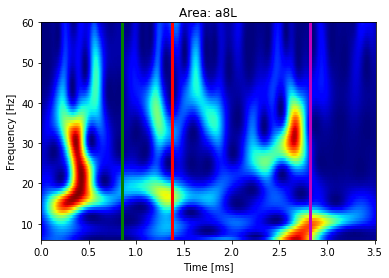

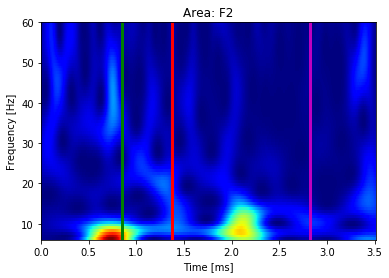

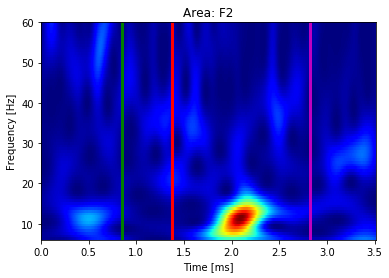

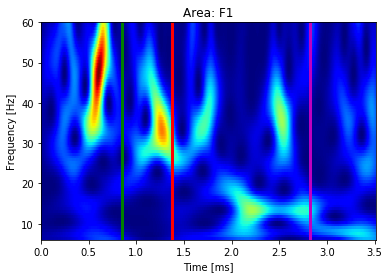

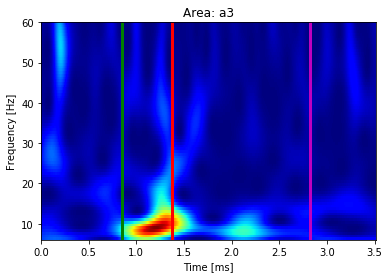

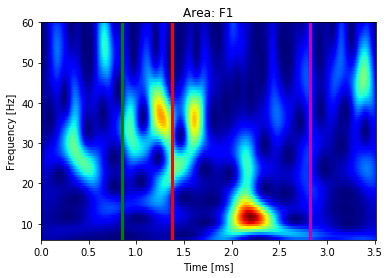

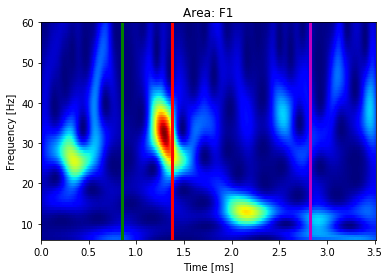

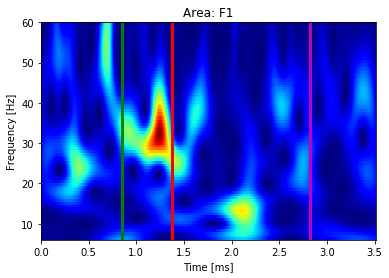

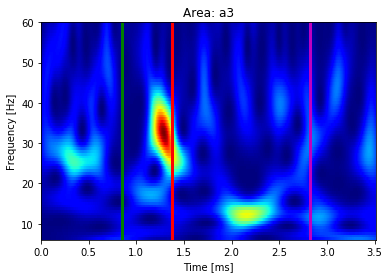

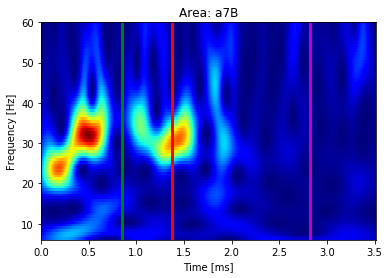

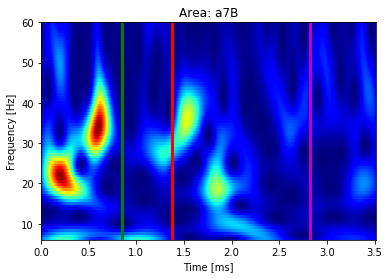

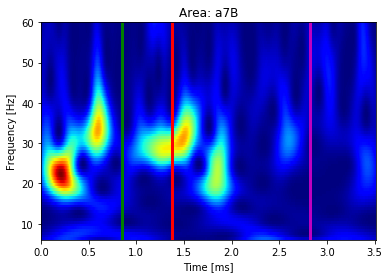

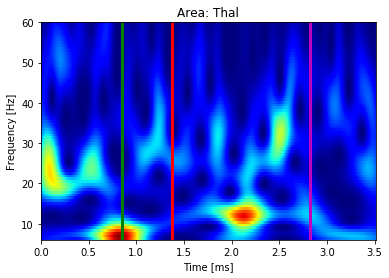

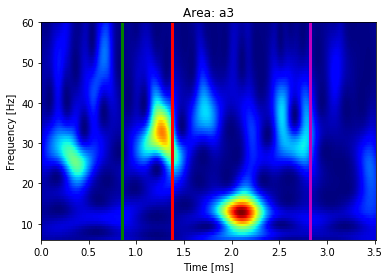

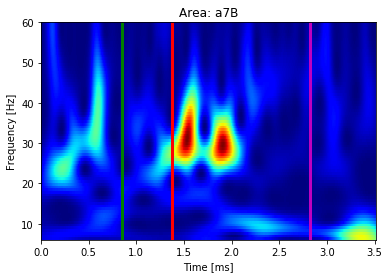

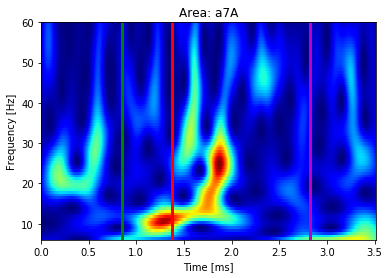

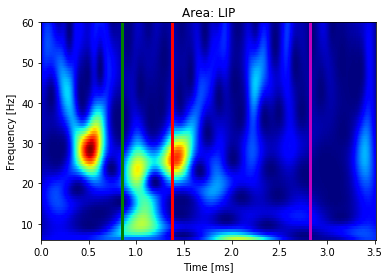

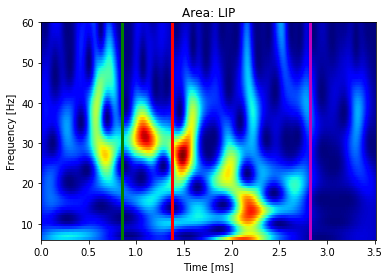

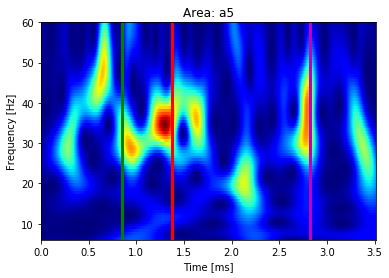

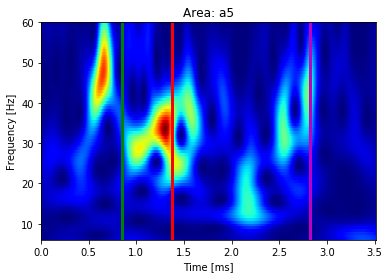

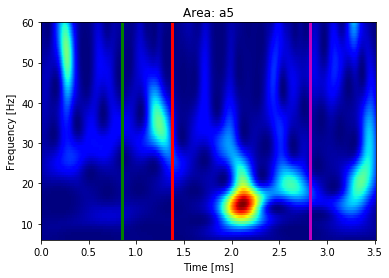

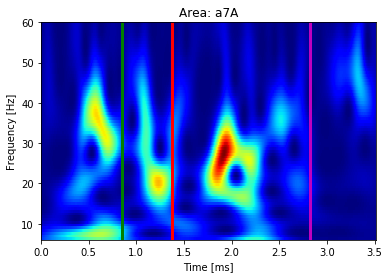

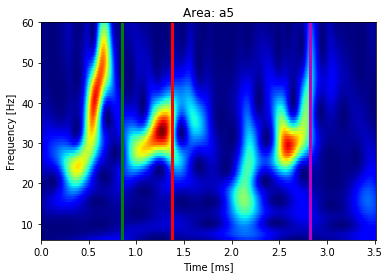

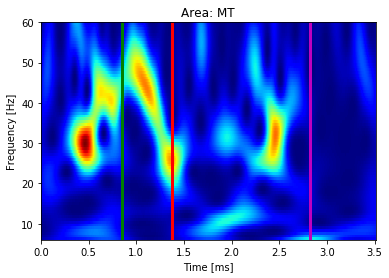

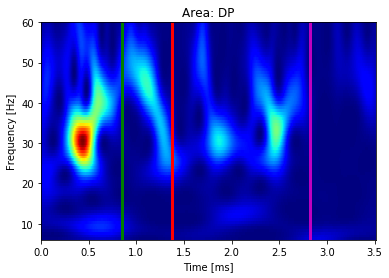

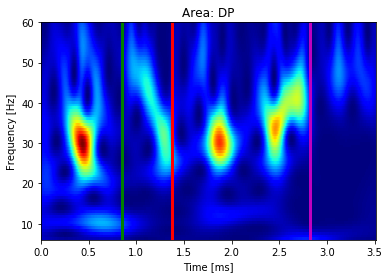

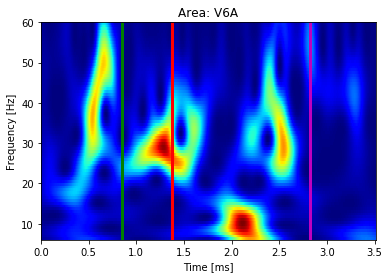

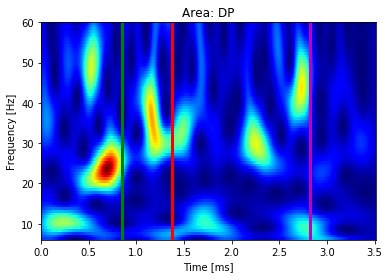

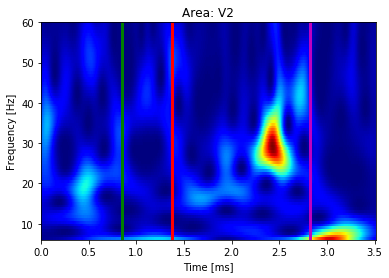

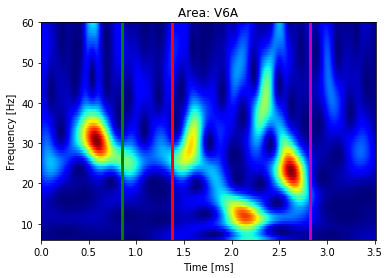

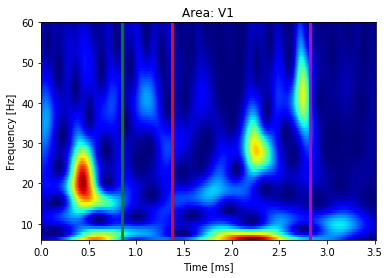

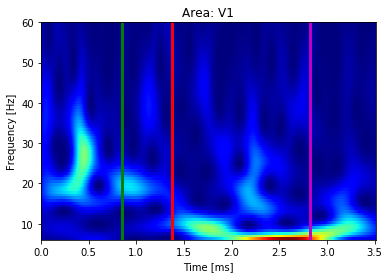

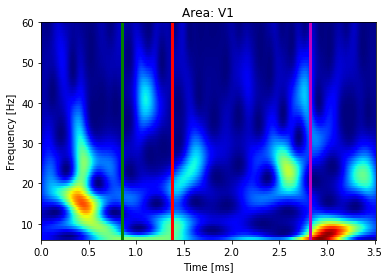

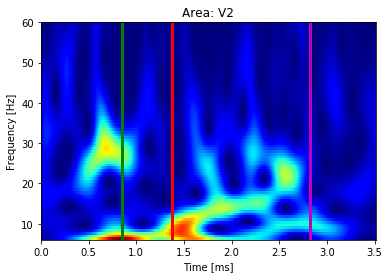

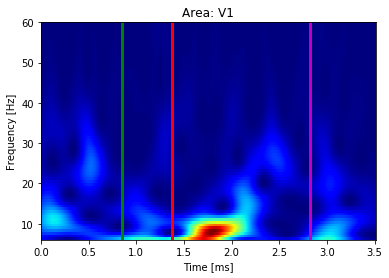

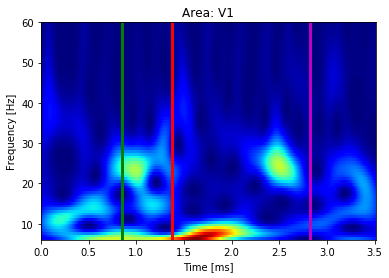

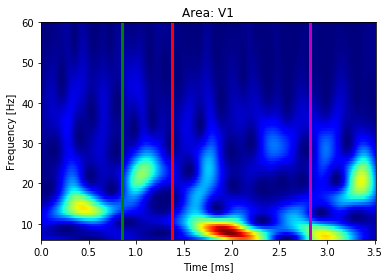

In [35]:
plot_figs(np.squeeze(out), 49, 
          lfp_data.readinfo['t_cue_on'][0], 
          lfp_data.readinfo['t_cue_off'][0],
          lfp_data.readinfo['t_match_on'][0]
         )

Now for all the trials at once, I think it averages the power for all trials in this case. 

In [17]:
st_power, itc, freqs = mne.time_frequency.tfr_array_stockwell(lfp_data.data, info['sfreq'], fmin=6, fmax=60, n_jobs=-1)

<ipython-input-17-01224772324b>:1: RuntimeWarning: The input signal is shorter (3651) than "n_fft" (4096). Applying zero padding.
  st_power, itc, freqs = mne.time_frequency.tfr_array_stockwell(lfp_data.data, info['sfreq'], fmin=6, fmax=60, n_jobs=-1)
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done  20 out of  49 | elapsed:  1.5min remaining:  2.2min
[Parallel(n_jobs=40)]: Done  30 out of  49 | elapsed:  1.7min remaining:  1.1min
[Parallel(n_jobs=40)]: Done  40 out of  49 | elapsed:  1.7min remaining:   23.4s
[Parallel(n_jobs=40)]: Done  49 out of  49 | elapsed:  1.9min finished


In this case I'll use the mean value of "t_cue_on", "t_cue_off", and "t_match_on" to plot the vertical lines indicating those events.

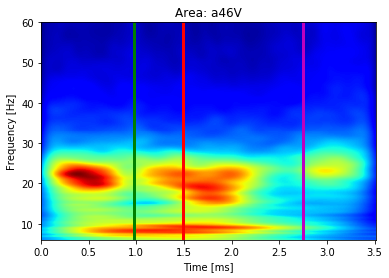

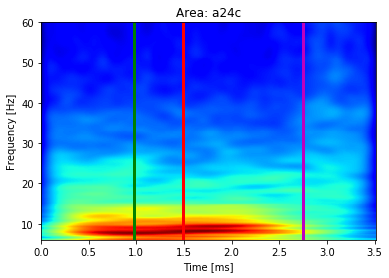

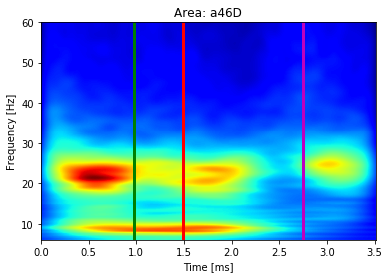

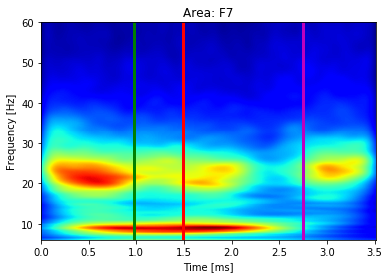

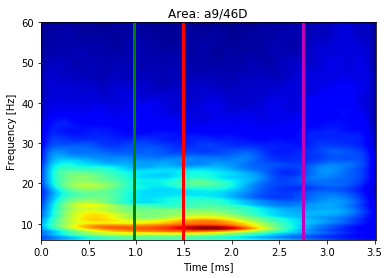

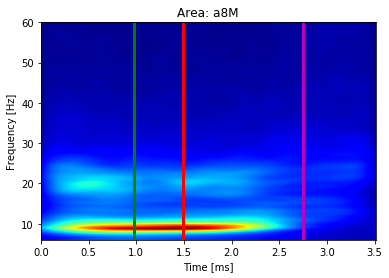

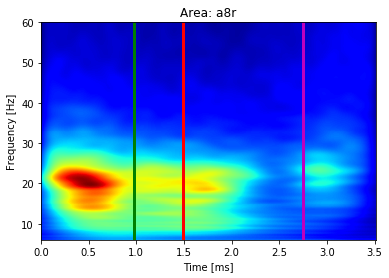

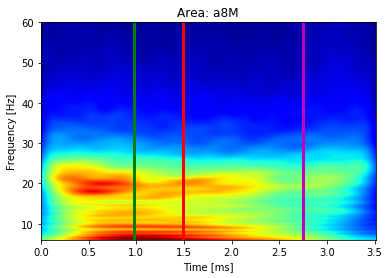

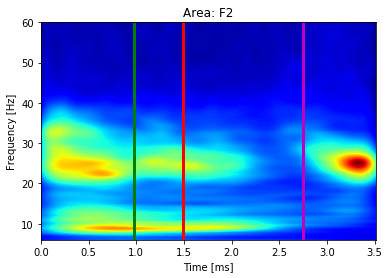

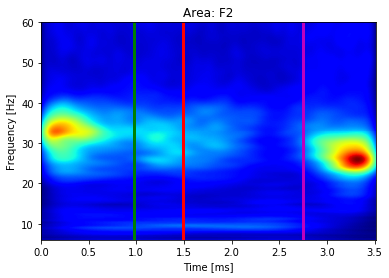

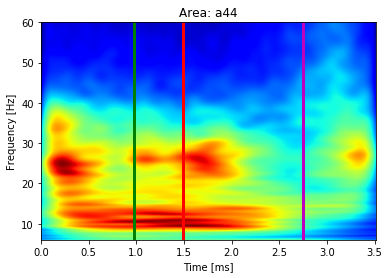

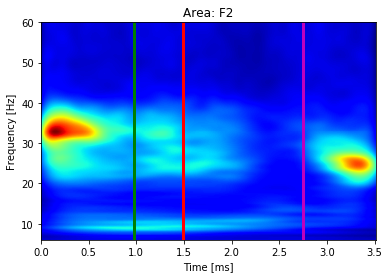

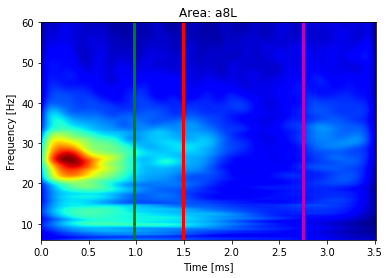

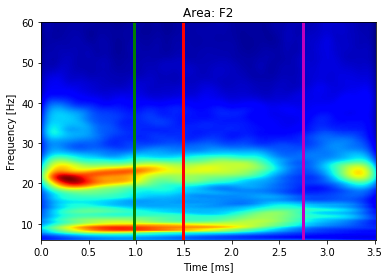

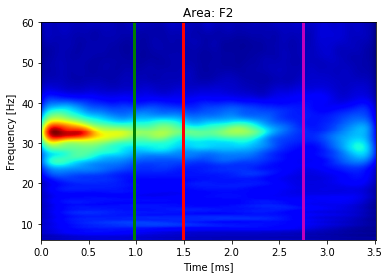

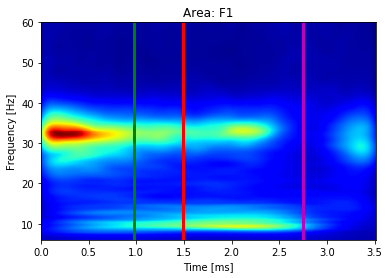

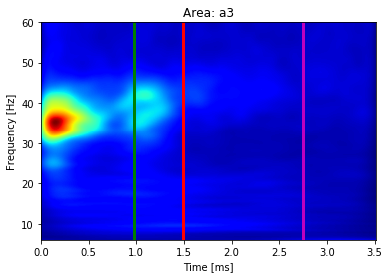

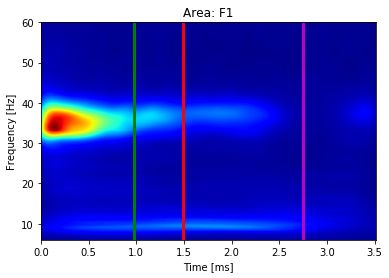

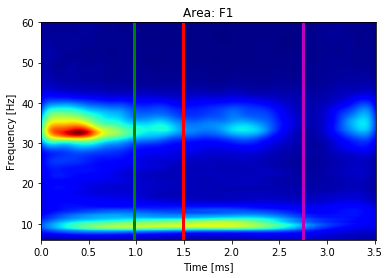

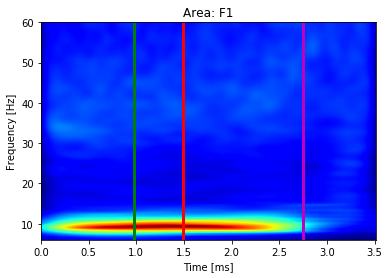

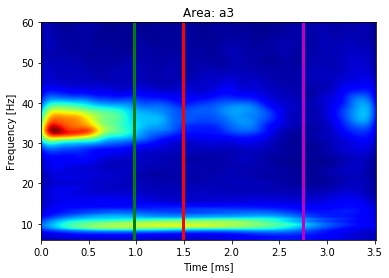

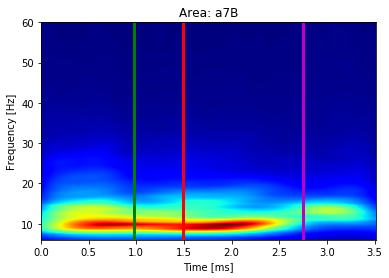

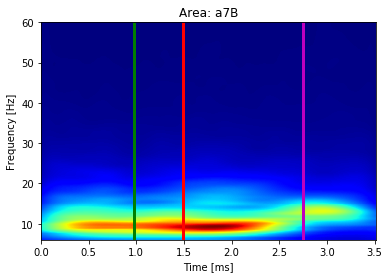

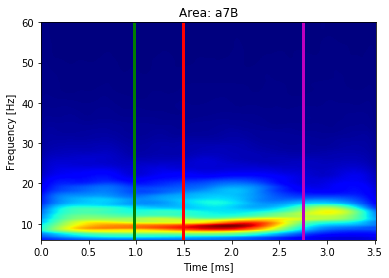

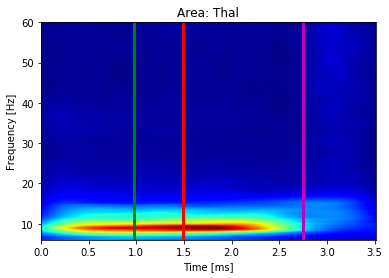

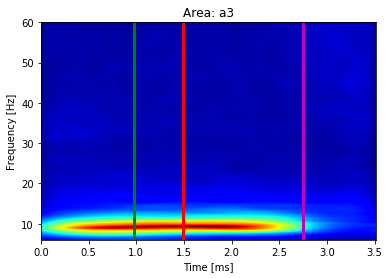

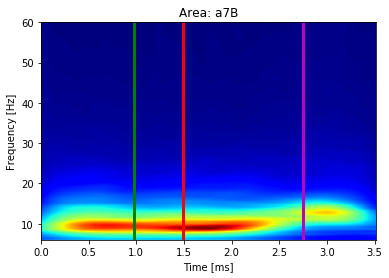

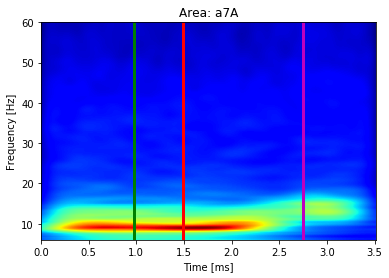

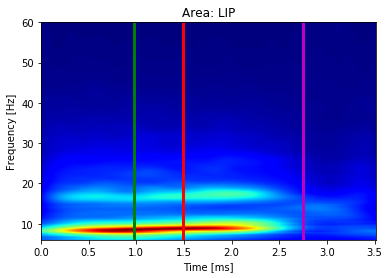

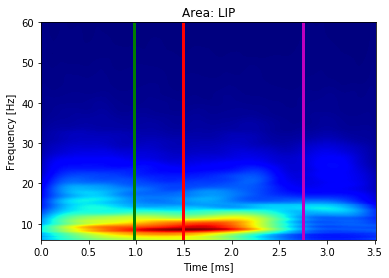

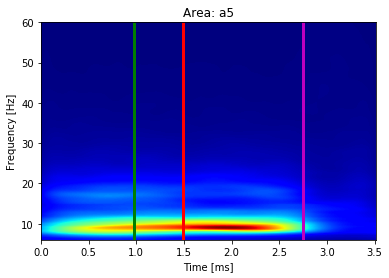

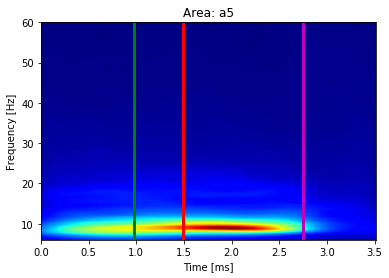

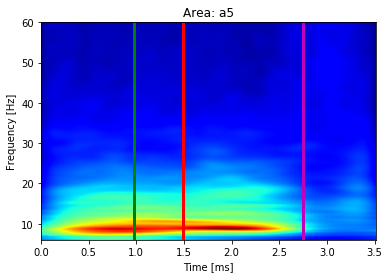

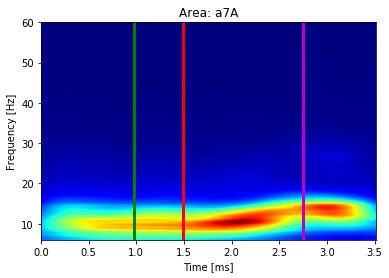

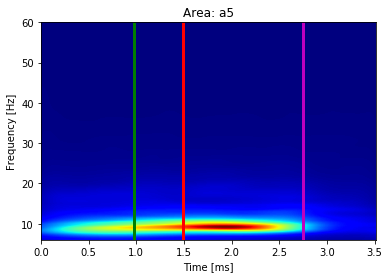

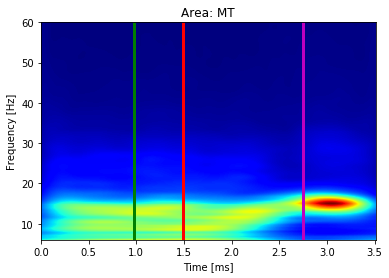

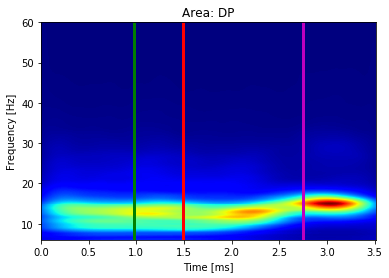

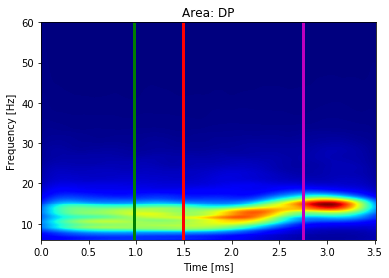

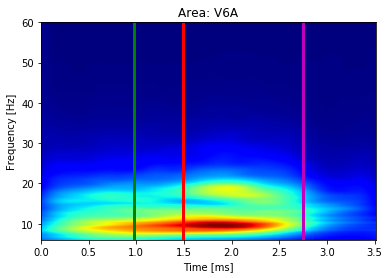

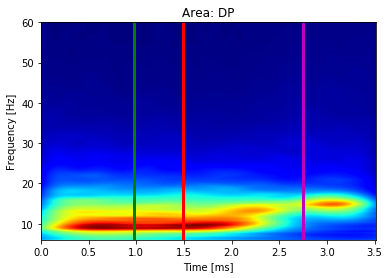

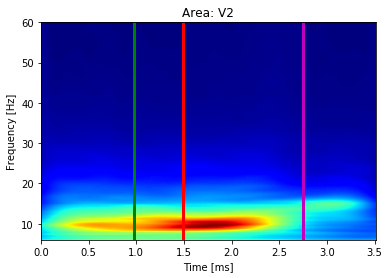

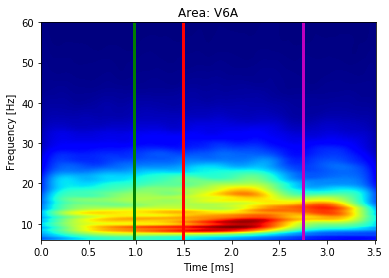

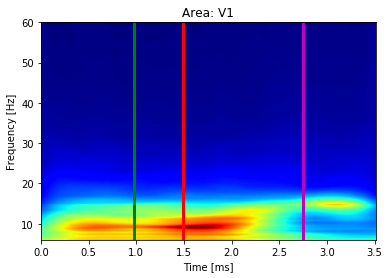

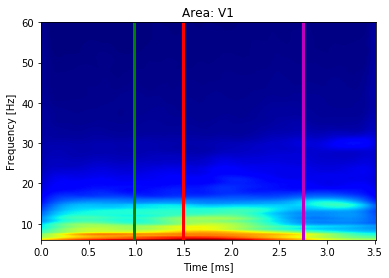

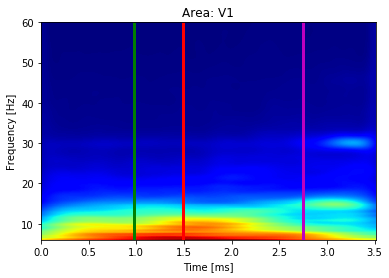

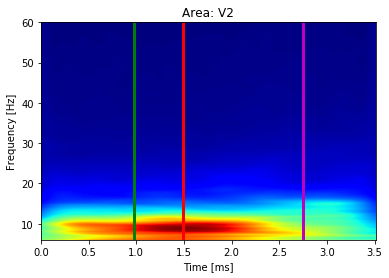

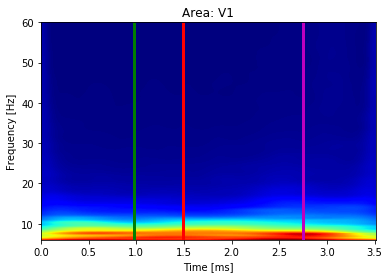

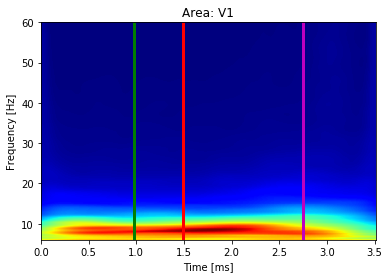

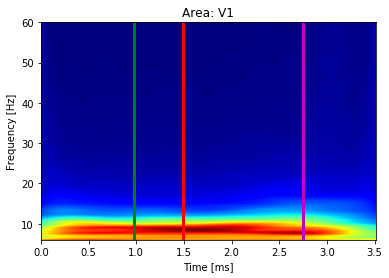

In [18]:
plot_figs(st_power, 49, 
          lfp_data.readinfo['t_cue_on'].mean(), 
          lfp_data.readinfo['t_cue_off'].mean(),
          lfp_data.readinfo['t_match_on'].mean()
         )

I've run it using 40 cores, so it is pretty fast! If we look at the documentation of "mne.time_frequency.tfr_array_stockwell" we see that it is possible to return the interareal coherences by setting "return_itc = True", let's test this for one trial of the data.

In [19]:
st_power, itc, freqs = mne.time_frequency.tfr_array_stockwell(lfp_data.data[0,:,:][np.newaxis, :, :], info['sfreq'], return_itc = True, fmin=6, fmax=60, n_jobs=-1)

<ipython-input-19-f4823f634bd4>:1: RuntimeWarning: The input signal is shorter (3651) than "n_fft" (4096). Applying zero padding.
  st_power, itc, freqs = mne.time_frequency.tfr_array_stockwell(lfp_data.data[0,:,:][np.newaxis, :, :], info['sfreq'], return_itc = True, fmin=6, fmax=60, n_jobs=-1)
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done  20 out of  49 | elapsed:    1.4s remaining:    2.1s
[Parallel(n_jobs=40)]: Done  30 out of  49 | elapsed:    2.1s remaining:    1.3s
[Parallel(n_jobs=40)]: Done  40 out of  49 | elapsed:    3.0s remaining:    0.7s
[Parallel(n_jobs=40)]: Done  49 out of  49 | elapsed:    3.8s finished


The coherecens should be returned in the variable "itc", it returned all "1". I'll test another method called "mne.time_frequency.tfr_array_multitaper", the interareal coherences are returned by setting "ouput = 'itc'".

In [20]:
freqs = np.linspace(6, 60, 500)
out = mne.time_frequency.tfr_array_multitaper(lfp_data.data[0,:,:][np.newaxis, :, :], info['sfreq'], freqs, output='itc', n_jobs=-1, verbose=None)

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done  20 out of  49 | elapsed:    3.3s remaining:    4.7s
[Parallel(n_jobs=40)]: Done  30 out of  49 | elapsed:    4.8s remaining:    3.1s
[Parallel(n_jobs=40)]: Done  40 out of  49 | elapsed:    5.7s remaining:    1.3s
[Parallel(n_jobs=40)]: Done  49 out of  49 | elapsed:    6.4s finished


Apparently does not work as well.

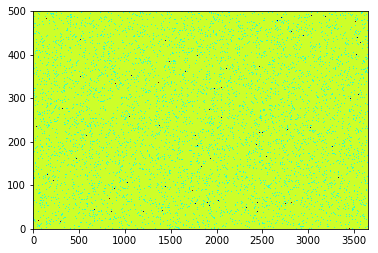

In [14]:
plt.imshow(out[1, :, :], aspect='auto', cmap='jet', origin='lower')

Testing the "mne.connectivity.spectral_connectivity" method for one trial.

In [11]:
con, freqs, times, n_epochs, n_tapers = mne.connectivity.spectral_connectivity(lfp_data.data[0,:,:][np.newaxis, :, :], method='coh',  sfreq=info['sfreq'], mode='multitaper', fmin=6, fmax=60, n_jobs = -1)

Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 1176 connections
    using t=0.000s..3.650s for estimation (3651 points)
    frequencies: 6.0Hz..60.0Hz (198 points)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence
    computing connectivity for epochs 1..1


[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    assembling connectivity matrix (filling the upper triangular region of the matrix)
[Connectivity computation done]


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    2.9s finished


We can plot the connetivity matrices for each frequency! Let's plot for ten different frequencies.

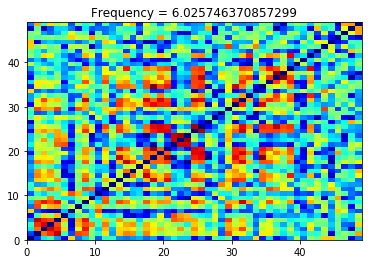

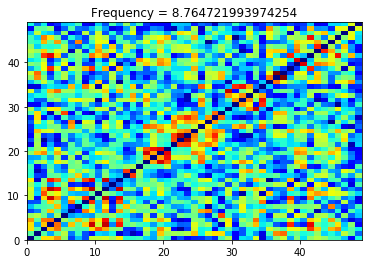

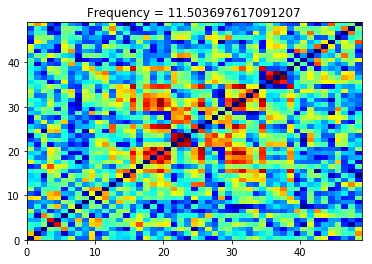

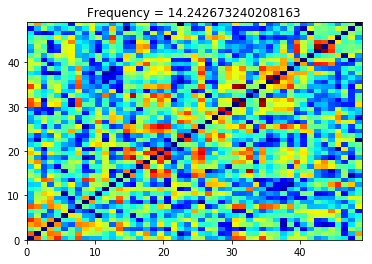

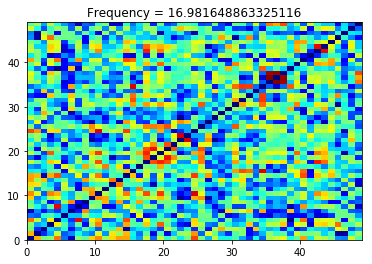

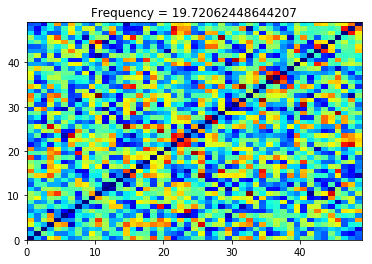

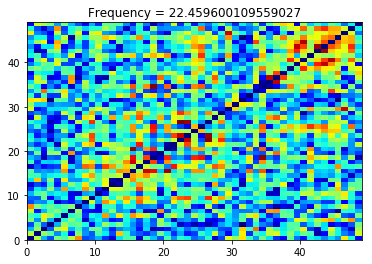

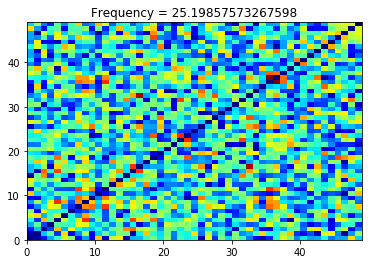

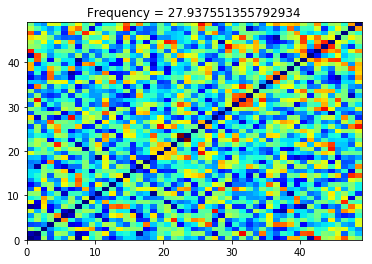

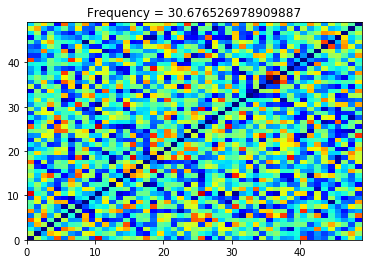

In [16]:
for i in [0, 10, 20, 30, 40, 50, 60,70, 80, 90]:
    plt.title('Frequency = ' + str(freqs[i]))
    plt.imshow(con[:,:,i]+con[:,:,i].T, aspect='auto', cmap='jet', extent=[0, 49, 0, 49], origin='lower')
    plt.show()

Now for all the trials.

In [17]:
con, freqs, times, n_epochs, n_tapers = mne.connectivity.spectral_connectivity(lfp_data.data, method='coh',  sfreq=info['sfreq'], mode='multitaper', fmin=6, fmax=60, n_jobs = -1)

Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 1176 connections
    using t=0.000s..3.650s for estimation (3651 points)
    frequencies: 6.0Hz..60.0Hz (198 points)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence
    computing connectivity for epochs 1..1


[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 2..2


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 3..3


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 4..4


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 5..5


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 6..6


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 7..7


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 8..8


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 9..9


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 10..10


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 11..11


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 12..12


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 13..13


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 14..14


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 15..15


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 16..16


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 17..17


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 18..18


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 19..19


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 20..20


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 21..21


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 22..22


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 23..23


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 24..24


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 25..25


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 26..26


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 27..27


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 28..28


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 29..29


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 30..30


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 31..31


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 32..32


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 33..33


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 34..34


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 35..35


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 36..36


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 37..37


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 38..38


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 39..39


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 40..40


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 41..41


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 42..42


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 43..43


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 44..44


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 45..45


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 46..46


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 47..47


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 48..48


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 49..49


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 50..50


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 51..51


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 52..52


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 53..53


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 54..54


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.3s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 55..55


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 56..56


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 57..57


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 58..58


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 59..59


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 60..60


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 61..61


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 62..62


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 63..63


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 64..64


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 65..65


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 66..66


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 67..67


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 68..68


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 69..69


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 70..70


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 71..71


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 72..72


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 73..73


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 74..74


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 75..75


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 76..76


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 77..77


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 78..78


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 79..79


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 80..80


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 81..81


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 82..82


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 83..83


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 84..84


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 85..85


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 86..86


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 87..87


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 88..88


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 89..89


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 90..90


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 91..91


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 92..92


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 93..93


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 94..94


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 95..95


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 96..96


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 97..97


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 98..98


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 99..99


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 100..100


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 101..101


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 102..102


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 103..103


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 104..104


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 105..105


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 106..106


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 107..107


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 108..108


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 109..109


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 110..110


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 111..111


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 112..112


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 113..113


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 114..114


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 115..115


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 116..116


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 117..117


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 118..118


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 119..119


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 120..120


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 121..121


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 122..122


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 123..123


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 124..124


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 125..125


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 126..126


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 127..127


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 128..128


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 129..129


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 130..130


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 131..131


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 132..132


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 133..133


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 134..134


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 135..135


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 136..136


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 137..137


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 138..138


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 139..139


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 140..140


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 141..141


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 142..142


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 143..143


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 144..144


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 145..145


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 146..146


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 147..147


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 148..148


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 149..149


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 150..150


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 151..151


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 152..152


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 153..153


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 154..154


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 155..155


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 156..156


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 157..157


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 158..158


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 159..159


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 160..160


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 161..161


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 162..162


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 163..163


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 164..164


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 165..165


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 166..166


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 167..167


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 168..168


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 169..169


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 170..170


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 171..171


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 172..172


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 173..173


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 174..174


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 175..175


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 176..176


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 177..177


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 178..178


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 179..179


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 180..180


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 181..181


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 182..182


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 183..183


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 184..184


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 185..185


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 186..186


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 187..187


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 188..188


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 189..189


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 190..190


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 191..191


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 192..192


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 193..193


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 194..194


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 195..195


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 196..196


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 197..197


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 198..198


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 199..199


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 200..200


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 201..201


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 202..202


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 203..203


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 204..204


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 205..205


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 206..206


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 207..207


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 208..208


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 209..209


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 210..210


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 211..211


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 212..212


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 213..213


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 214..214


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 215..215


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 216..216


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 217..217


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 218..218


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 219..219


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 220..220


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 221..221


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 222..222


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 223..223


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 224..224


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 225..225


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 226..226


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 227..227


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 228..228


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 229..229


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 230..230


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 231..231


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 232..232


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 233..233


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 234..234


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 235..235


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 236..236


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 237..237


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 238..238


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 239..239


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 240..240


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 241..241


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 242..242


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 243..243


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 244..244


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 245..245


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 246..246


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 247..247


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 248..248


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 249..249


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 250..250


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 251..251


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 252..252


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 253..253


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 254..254


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 255..255


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 256..256


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 257..257


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 258..258


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 259..259


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 260..260


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 261..261


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 262..262


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 263..263


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 264..264


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 265..265


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 266..266


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 267..267


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 268..268


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 269..269


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 270..270


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 271..271


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 272..272


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 273..273


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 274..274


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 275..275


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 276..276


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 277..277


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 278..278


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 279..279


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 280..280


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 281..281


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 282..282


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 283..283


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 284..284


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 285..285


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 286..286


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 287..287


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 288..288


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 289..289


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 290..290


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 291..291


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 292..292


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 293..293


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 294..294


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 295..295


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 296..296


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 297..297


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 298..298


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 299..299


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 300..300


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 301..301


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 302..302


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 303..303


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 304..304


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 305..305


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 306..306


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 307..307


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 308..308


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 309..309


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 310..310


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 311..311


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 312..312


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 313..313


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 314..314


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 315..315


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 316..316


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 317..317


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 318..318


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 319..319


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 320..320


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 321..321


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 322..322


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 323..323


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 324..324


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 325..325


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 326..326


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 327..327


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 328..328


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 329..329


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 330..330


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 331..331


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 332..332


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 333..333


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 334..334


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 335..335


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 336..336


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 337..337


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 338..338


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 339..339


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 340..340


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 341..341


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 342..342


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 343..343


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 344..344


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.3s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 345..345


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 346..346


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 347..347


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 348..348


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 349..349


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 350..350


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 351..351


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 352..352


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 353..353


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 354..354


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 355..355


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 356..356


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 357..357


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 358..358


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 359..359


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 360..360


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 361..361


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 362..362


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 363..363


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 364..364


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 365..365


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 366..366


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 367..367


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 368..368


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 369..369


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 370..370


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 371..371


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 372..372


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 373..373


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 374..374


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 375..375


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 376..376


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 377..377


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 378..378


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 379..379


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 380..380


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 381..381


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 382..382


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 383..383


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 384..384


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 385..385


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 386..386


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 387..387


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 388..388


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 389..389


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 390..390


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 391..391


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 392..392


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 393..393


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 394..394


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 395..395


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 396..396


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 397..397


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 398..398


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 399..399


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 400..400


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 401..401


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 402..402


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 403..403


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 404..404


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 405..405


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 406..406


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 407..407


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 408..408


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 409..409


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 410..410


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 411..411


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 412..412


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 413..413


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 414..414


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 415..415


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 416..416


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 417..417


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 418..418


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 419..419


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 420..420


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 421..421


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 422..422


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 423..423


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 424..424


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 425..425


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 426..426


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 427..427


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 428..428


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 429..429


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 430..430


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 431..431


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 432..432


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 433..433


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 434..434


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 435..435


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 436..436


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 437..437


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 438..438


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 439..439


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 440..440


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 441..441


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 442..442


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 443..443


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 444..444


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 445..445


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 446..446


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 447..447


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 448..448


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 449..449


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 450..450


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 451..451


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 452..452


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 453..453


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 454..454


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 455..455


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 456..456


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 457..457


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 458..458


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 459..459


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 460..460


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 461..461


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 462..462


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 463..463


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 464..464


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 465..465


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 466..466


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 467..467


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 468..468


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 469..469


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 470..470


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 471..471


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 472..472


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 473..473


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 474..474


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 475..475


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 476..476


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 477..477


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 478..478


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 479..479


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 480..480


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 481..481


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 482..482


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 483..483


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 484..484


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 485..485


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 486..486


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 487..487


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 488..488


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 489..489


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 490..490


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 491..491


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 492..492


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 493..493


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.3s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 494..494


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 495..495


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 496..496


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 497..497


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 498..498


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 499..499


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 500..500


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 501..501


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 502..502


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 503..503


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 504..504


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 505..505


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 506..506


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 507..507


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 508..508


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 509..509


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 510..510


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 511..511


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 512..512


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 513..513


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 514..514


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 515..515


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 516..516


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 517..517


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 518..518


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 519..519


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 520..520


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.3s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 521..521


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 522..522


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 523..523


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 524..524


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 525..525


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 526..526


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 527..527


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 528..528


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 529..529


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 530..530


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 531..531


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 532..532


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 533..533


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 534..534


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 535..535


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 536..536


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 537..537


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 538..538


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 539..539


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 540..540


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.3s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    assembling connectivity matrix (filling the upper triangular region of the matrix)
[Connectivity computation done]


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.1s finished


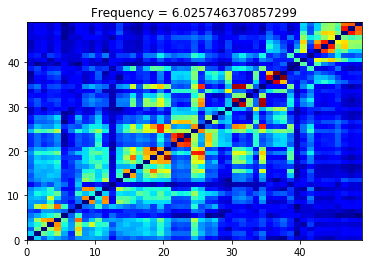

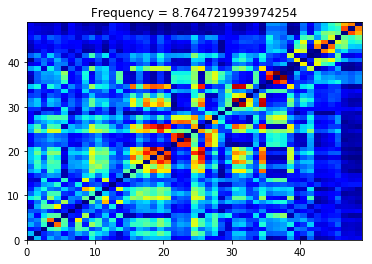

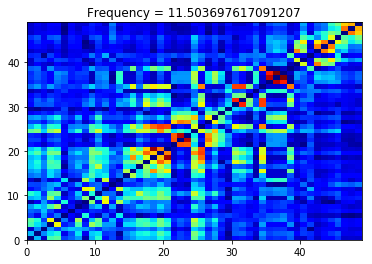

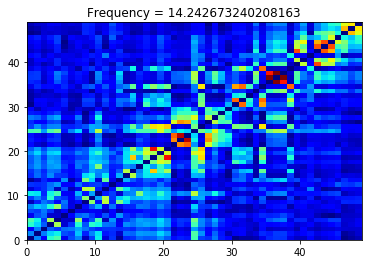

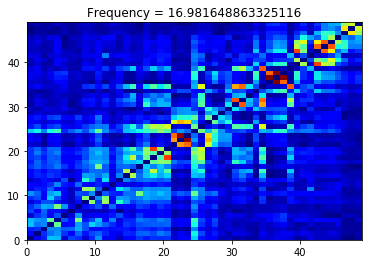

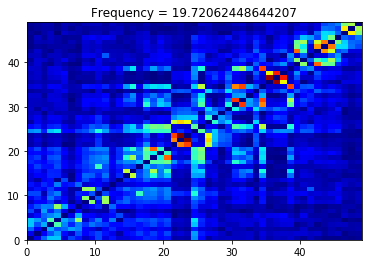

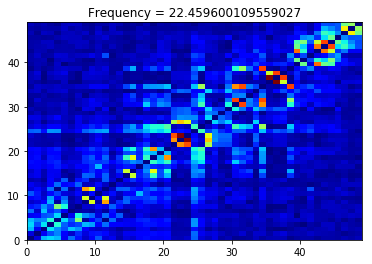

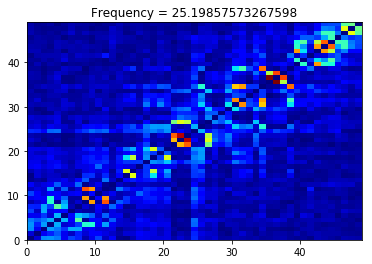

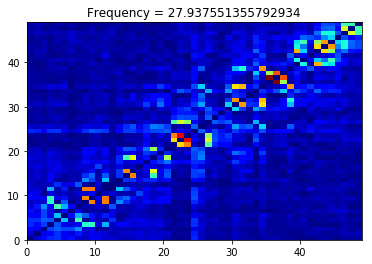

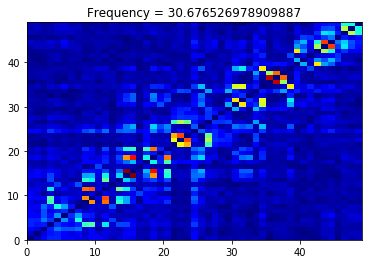

In [18]:
for i in [0, 10, 20, 30, 40, 50, 60,70, 80, 90]:
    plt.title('Frequency = ' + str(freqs[i]))
    plt.imshow(con[:,:,i]+con[:,:,i].T, aspect='auto', cmap='jet', extent=[0, 49, 0, 49], origin='lower')
    plt.show()